Unüberwachtes Lernen zur Kundensegmentierung

Ein Einzelhandelsunternehmen möchte seine Kunden in Gruppen einteilen, um für jede Gruppe geeignete Marketingstrategien zu entwickeln. Zu diesem Zweck werden die bisherigen Einkaufsgewohnheiten der Kunden untersucht, und Kunden mit ähnlichen Eigenschaften werden in Segmente unterteilt.

Informationen zum Datensatz

Der Datensatz umfasst die bisherigen Einkaufsgewohnheiten von Kunden, die in bestimmten Jahren sowohl online als auch offline eingekauft haben.

Merkmale:

cust_id : Eindeutige Kundennummer

purchase_channel : Kanal, über den die Bestellung aufgegeben wurde (z. B. Android, iOS, Desktop, Mobile)

recent_channel : Kanal, über den die letzte Bestellung aufgegeben wurde

first_purchase_date : Datum des ersten Einkaufs

last_purchase_date : Datum des letzten Einkaufs

last_online_date : Datum des letzten Online-Einkaufs

last_offline_date : Datum des letzten Offline-Einkaufs

num_orders_online : Gesamtanzahl der Online-Einkäufe

num_orders_offline : Gesamtanzahl der Offline-Einkäufe

spend_offline_total : Gesamtausgaben bei Offline-Einkäufen

spend_online_total : Gesamtausgaben bei Online-Einkäufen

categories_last12 : Kategorien, in denen in den letzten 12 Monaten eingekauft wurde

In [ ]:
# Installation der benötigten Bibliotheken
!pip install -q yellowbrick
import numpy as np
import pandas as pd
import seaborn as sns
import random
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Anzeigeeinstellungen für Pandas
pd.set_option('display.max_columns', 50)  
# → Maximale Anzahl der anzuzeigenden Spalten = 50

pd.set_option('display.max_rows', 80)  
# → Maximale Anzahl der anzuzeigenden Zeilen = 80

pd.set_option('display.float_format', lambda x: '%.3f' % x)  
# → Dezimalzahlen werden mit 3 Nachkommastellen angezeigt

pd.set_option('display.width', 500)  
# → Maximale Breite der Tabellenausgabe = 500 Zeichen

# Warnungen ausblenden
warnings.simplefilter(action='ignore')  
# → Unterdrückt unnötige Warnmeldungen in der Ausgabe


In [3]:
#Einlesen des Datensatzes
df = pd.read_csv("/Users/nesri/repos/segmentasyon/X_data.csv")
df.head()

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN]
1,"f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android A...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"69b69676-1a40-11ea-941b-000d3a38a36f,Android A...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"1854e56c-491f-11eb-806e-000d3a38a36f,Android A...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR]


In [4]:
#Überprüfung fehlender Werte
df.isnull().sum()

cust_id                   0
purchase_channel       8700
recent_channel         8700
first_purchase_date    8700
last_purchase_date     8700
last_online_date       8700
last_offline_date      8700
num_orders_online      8700
num_orders_offline     8700
spend_offline_total    8700
spend_online_total     8700
categories_last12      8700
dtype: int64

In [5]:
#Bereinigung des Datensatzes
with open("X_data.csv", "r", encoding="utf-8") as f:
    lines = f.readlines()
cleaned_rows = []
for line in lines:
    parts = line.strip().split(",")
    
    # Eğer ilk hücrede fazladan virgül varsa, düzelt
    if len(parts) > 12:
        cust_id = parts[0]
        purchase_channel = parts[1]
        recent_channel = parts[2]
        rest = parts[3:]
        fixed_row = [cust_id, purchase_channel, recent_channel] + rest
        cleaned_rows.append(fixed_row[:12])  # Fazla sütun varsa kes
    elif len(parts) == 12:
        cleaned_rows.append(parts)

columns = ["cust_id", "purchase_channel", "recent_channel", "first_purchase_date", "last_purchase_date",
           "last_online_date", "last_offline_date", "num_orders_online", "num_orders_offline",
           "spend_offline_total", "spend_online_total", "categories_last12"]

df = pd.DataFrame(cleaned_rows[1:], columns=columns)  # [1:] başlık satırını atar

In [6]:
df.head()

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,"""f431bd5a-ab7b-11e9-a2fc-000d3a38a36f",Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"""""[ERKEK"
2,"""69b69676-1a40-11ea-941b-000d3a38a36f",Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"""""[ERKEK"
3,"""1854e56c-491f-11eb-806e-000d3a38a36f",Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"""""[AKTIFCOCUK"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [7]:
df.isnull().sum()

cust_id                0
purchase_channel       0
recent_channel         0
first_purchase_date    0
last_purchase_date     0
last_online_date       0
last_offline_date      0
num_orders_online      0
num_orders_offline     0
spend_offline_total    0
spend_online_total     0
categories_last12      0
dtype: int64

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cust_id              19945 non-null  object
 1   purchase_channel     19945 non-null  object
 2   recent_channel       19945 non-null  object
 3   first_purchase_date  19945 non-null  object
 4   last_purchase_date   19945 non-null  object
 5   last_online_date     19945 non-null  object
 6   last_offline_date    19945 non-null  object
 7   num_orders_online    19945 non-null  object
 8   num_orders_offline   19945 non-null  object
 9   spend_offline_total  19945 non-null  object
 10  spend_online_total   19945 non-null  object
 11  categories_last12    19945 non-null  object
dtypes: object(12)
memory usage: 1.8+ MB


In [9]:
df.shape

(19945, 12)

In [10]:
# Umwandlung der Datums-Spalten in das datetime-Format
date_cols = ['first_purchase_date', 'last_purchase_date', 'last_online_date', 'last_offline_date']
for col in date_cols:
 df[col] = pd.to_datetime(df[col])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cust_id              19945 non-null  object        
 1   purchase_channel     19945 non-null  object        
 2   recent_channel       19945 non-null  object        
 3   first_purchase_date  19945 non-null  datetime64[ns]
 4   last_purchase_date   19945 non-null  datetime64[ns]
 5   last_online_date     19945 non-null  datetime64[ns]
 6   last_offline_date    19945 non-null  datetime64[ns]
 7   num_orders_online    19945 non-null  object        
 8   num_orders_offline   19945 non-null  object        
 9   spend_offline_total  19945 non-null  object        
 10  spend_online_total   19945 non-null  object        
 11  categories_last12    19945 non-null  object        
dtypes: datetime64[ns](4), object(8)
memory usage: 1.8+ MB


In [12]:
#Umwandlung der numerischen Spalten in float
numeric_cols = ['num_orders_online', 'num_orders_offline', 'spend_offline_total', 'spend_online_total']

for col in numeric_cols:
     df[col] = pd.to_numeric( df[col], errors='coerce') 

print( df[numeric_cols].dtypes)


num_orders_online      float64
num_orders_offline     float64
spend_offline_total    float64
spend_online_total     float64
dtype: object


In [13]:
#Überprüfung auf doppelte Zeilen
df[df.duplicated()]

,cust_id,purchase_channel,recent_channel,first_purchase_date,last_purchase_date,last_online_date,last_offline_date,num_orders_online,num_orders_offline,spend_offline_total,spend_online_total,categories_last12


In [14]:
 df.describe().T

,count,mean,min,25%,50%,75%,max,std
first_purchase_date,19945,2019-03-22 16:43:55.246929152,2013-01-14 00:00:00,2019-02-16 00:00:00,2019-08-20 00:00:00,2020-01-01 00:00:00,2021-05-27 00:00:00,NaN
last_purchase_date,19945,2021-01-17 12:59:57.653547264,2020-05-30 00:00:00,2020-11-11 00:00:00,2021-02-10 00:00:00,2021-04-19 00:00:00,2021-05-30 00:00:00,NaN
last_online_date,19945,2020-08-10 01:08:52.644773376,2014-02-24 00:00:00,2020-06-18 00:00:00,2020-12-14 00:00:00,2021-04-05 00:00:00,2021-05-30 00:00:00,NaN
last_offline_date,19945,2020-05-17 12:07:24.021058048,2019-01-22 00:00:00,2019-11-04 00:00:00,2020-06-22 00:00:00,2020-12-25 00:00:00,2021-05-28 00:00:00,NaN
num_orders_online,19945.000,3.111,1.000,1.000,2.000,4.000,200.000,4.226
num_orders_offline,19945.000,1.914,1.000,1.000,1.000,2.000,109.000,2.063
spend_offline_total,19945.000,253.923,10.000,99.990,179.980,319.970,18119.140,301.533
spend_online_total,19945.000,497.322,12.990,149.980,286.460,578.440,45220.130,832.602


In [15]:
# Alle Spaltennamen in Großbuchstaben umwandeln
df.columns = [col.upper() for col in df.columns]

# Kontrolle
print(df.columns)

Index(['CUST_ID', 'PURCHASE_CHANNEL', 'RECENT_CHANNEL', 'FIRST_PURCHASE_DATE', 'LAST_PURCHASE_DATE', 'LAST_ONLINE_DATE', 'LAST_OFFLINE_DATE', 'NUM_ORDERS_ONLINE', 'NUM_ORDERS_OFFLINE', 'SPEND_OFFLINE_TOTAL', 'SPEND_ONLINE_TOTAL', 'CATEGORIES_LAST12'], dtype='object')


In [16]:
# Analysedatum = Das Datum des letzten Kaufs im Datensatz
analysis_date = df['LAST_PURCHASE_DATE'].max()

# Recency (Die Zeitspanne seit dem letzten Kauf eines Kunden)
df['RECENCY'] = (analysis_date - df['LAST_PURCHASE_DATE']).dt.days

In [17]:
# Tenure (Die Zeitspanne seit dem ersten Kauf eines Kunden)
df['TENURE'] = (df['LAST_PURCHASE_DATE'] - df['FIRST_PURCHASE_DATE']).dt.days


In [18]:
#Monetary (Gesamtausgaben eines Kunden (online + offline))
df['MONETARY'] = df['SPEND_ONLINE_TOTAL'] + df['SPEND_OFFLINE_TOTAL']

In [19]:
#Frequency (Gesamte Anzahl der Einkäufe eines Kunden (online + offline))
df['FREQUENCY'] = df['NUM_ORDERS_ONLINE'] + df['NUM_ORDERS_OFFLINE']

In [26]:
print(df.columns)

Index(['CUST_ID', 'PURCHASE_CHANNEL', 'RECENT_CHANNEL', 'FIRST_PURCHASE_DATE', 'LAST_PURCHASE_DATE', 'LAST_ONLINE_DATE', 'LAST_OFFLINE_DATE', 'NUM_ORDERS_ONLINE', 'NUM_ORDERS_OFFLINE', 'SPEND_OFFLINE_TOTAL', 'SPEND_ONLINE_TOTAL', 'CATEGORIES_LAST12', 'RECENCY', 'TENURE', 'MONETARY', 'FREQUENCY'], dtype='object')


In [27]:
#Skalierung der numerischen Spalten

# Numerische Spalten im Datensatz
numeric_cols = ['NUM_ORDERS_ONLINE', 'NUM_ORDERS_OFFLINE', 
                'SPEND_OFFLINE_TOTAL', 'SPEND_ONLINE_TOTAL', 
                'RECENCY', 'TENURE', 'MONETARY', 'FREQUENCY']

# MinMaxScaler: Werte auf den Bereich 0-1 skalieren
scaler = MinMaxScaler(feature_range=(0,1))
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Kontrolle: die ersten Zeilen anzeigen
print(df[numeric_cols].head())


   NUM_ORDERS_ONLINE  NUM_ORDERS_OFFLINE  SPEND_OFFLINE_TOTAL  SPEND_ONLINE_TOTAL  RECENCY  TENURE  MONETARY  FREQUENCY
0              0.015               0.000                0.007               0.017    0.255   0.039     0.020      0.015
1              0.090               0.009                0.008               0.041    0.282   0.484     0.043      0.095
2              0.010               0.009                0.010               0.008    0.504   0.121     0.012      0.015
3              0.000               0.000                0.002               0.002    0.364   0.004     0.002      0.000
4              0.000               0.000                0.002               0.003    0.230   0.192     0.004      0.000


In [28]:
#Berechnung der SSD für die Elbow-Methode mit K-Means
kmeans = KMeans()
ssd = []           # Sum of Squared Distances (Abweichung innerhalb der Cluster)
K = range(1, 30)   # Anzahl der Cluster testen

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[numeric_cols])  # Nur numerische Spalten verwenden
    ssd.append(kmeans.inertia_)   # SSD speichern


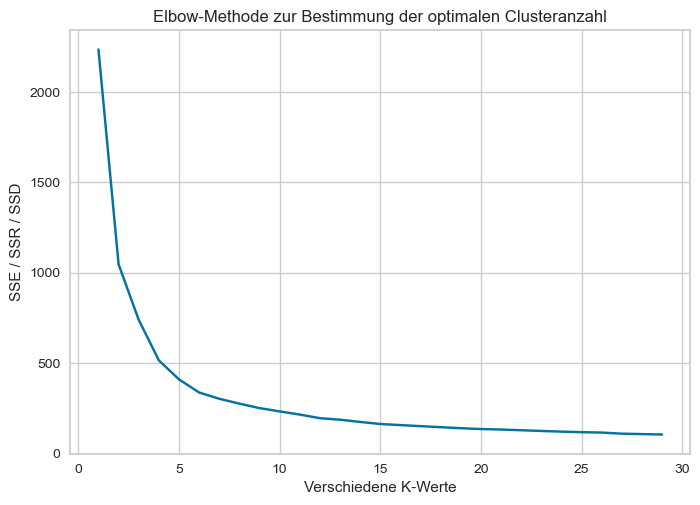

In [29]:
# Visualisierung der Elbow-Methode
plt.plot(K, ssd, 'bx-')
plt.xlabel("Verschiedene K-Werte")
plt.ylabel("SSE / SSR / SSD")
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusteranzahl")
plt.show()

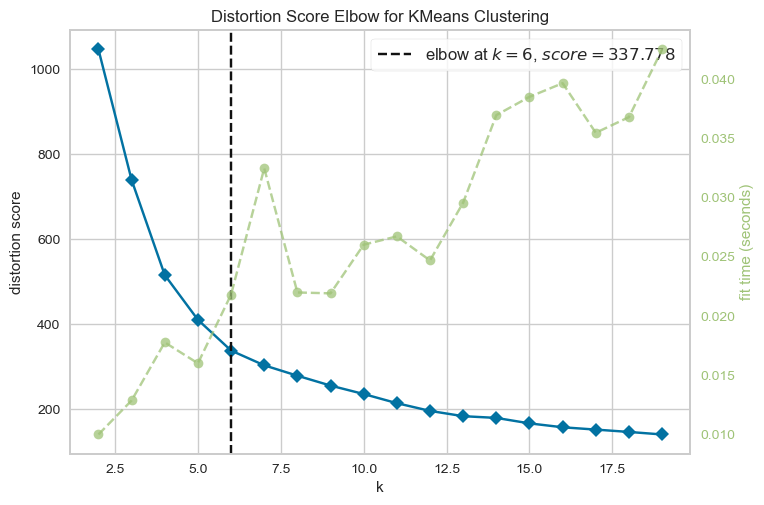

6


In [30]:
#Elbow-Methode mit K-Means und Bestimmung des optimalen K

# KMeans-Modell
kmeans = KMeans()

# K-Elbow (Testen von K zwischen 2 und 20)
elbow = KElbowVisualizer(kmeans, k=(2,20))
elbow.fit(df[numeric_cols])  # Nur numerische Spalten verwenden
elbow.show()

# Optimale Anzahl der Cluster
optimal_k = elbow.elbow_value_
print(optimal_k)


In [31]:
#Clustering mit K-Means und Zuweisung der Segmente

# Fit nur auf numerischen und skalierten Spalten
kmeans = KMeans(n_clusters=elbow.elbow_value_, random_state=42)
kmeans.fit(df[numeric_cols])

# Anzahl der Cluster
print("Anzahl der Cluster:", kmeans.n_clusters)

# Cluster-Zentren
print("Cluster-Zentren:\n", kmeans.cluster_centers_)

# Zuweisung jeder Beobachtung zu einem Cluster
df["kmeans_cluster_no"] = kmeans.labels_+ 1

# Erste 5 Zeilen zur Kontrolle
df.head()

Anzahl der Cluster: 6
Cluster-Zentren:
 [[0.00662285 0.00709606 0.01221587 0.00832333 0.54885939 0.15021352
  0.01254909 0.01042161]
 [0.01008025 0.00903069 0.01443799 0.0115444  0.08009035 0.18407468
  0.01660176 0.01490642]
 [0.02116187 0.00846217 0.01326524 0.01408219 0.7036516  0.56847883
  0.01864032 0.02562563]
 [0.00726185 0.00885187 0.01366692 0.00855258 0.29866759 0.1655039
  0.01334806 0.01200555]
 [0.03303997 0.01080897 0.01543712 0.0228633  0.18668074 0.60016045
  0.02815403 0.03871162]
 [0.00529557 0.00689956 0.01144024 0.00703036 0.87129793 0.12688293
  0.01096826 0.00899486]]


,CUST_ID,PURCHASE_CHANNEL,RECENT_CHANNEL,FIRST_PURCHASE_DATE,LAST_PURCHASE_DATE,LAST_ONLINE_DATE,LAST_OFFLINE_DATE,NUM_ORDERS_ONLINE,NUM_ORDERS_OFFLINE,SPEND_OFFLINE_TOTAL,SPEND_ONLINE_TOTAL,CATEGORIES_LAST12,RECENCY,TENURE,MONETARY,FREQUENCY,kmeans_cluster_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,0.015,0.000,0.007,0.017,[KADIN],0.255,0.039,0.020,0.015,4
1,"""f431bd5a-ab7b-11e9-a2fc-000d3a38a36f",Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,0.090,0.009,0.008,0.041,"""""[ERKEK",0.282,0.484,0.043,0.095,5
2,"""69b69676-1a40-11ea-941b-000d3a38a36f",Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,0.010,0.009,0.010,0.008,"""""[ERKEK",0.504,0.121,0.012,0.015,1
3,"""1854e56c-491f-11eb-806e-000d3a38a36f",Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,0.000,0.000,0.002,0.002,"""""[AKTIFCOCUK",0.364,0.004,0.002,0.000,4
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,0.000,0.000,0.002,0.003,[AKTIFSPOR],0.230,0.192,0.004,0.000,4


In [43]:
# Nur numerische Spalten
numeric_cols = df.select_dtypes(include=np.number).columns

# Clusterbasierte Zusammenfassung (nur numerische Spalten)
df.groupby("kmeans_cluster_no")[numeric_cols].agg(["count","mean","median"])


NUM_ORDERS_ONLINE              NUM_ORDERS_OFFLINE              SPEND_OFFLINE_TOTAL              SPEND_ONLINE_TOTAL              RECENCY              TENURE              MONETARY              FREQUENCY              kmeans_cluster_no             
                              count  mean median              count  mean median               count  mean median              count  mean median   count  mean median  count  mean median    count  mean median     count  mean median             count  mean median
kmeans_cluster_no                                                                                                                                                                                                                                                     
1                              3880 0.007  0.000               3880 0.007  0.000                3880 0.012  0.009               3880 0.008  0.005    3880 0.549  0.537   3880 0.150  0.142     3880 0.013  0.010      3880 0.010  0.005              3880 1.000  1.000
2                              6187 0.010  0.005               6187 0.009  0.000                6187 0.014  0.010               6187 0.012  0.007    6187 0.080  0.071   6187 0.184  0.188     6187 0.017  0.012      6187 0.015  0.010              6187 2.000  2.000
3                               998 0.021  0.010                998 0.008  0.000                 998 0.013  0.009                998 0.014  0.008     998 0.704  0.690    998 0.569  0.555      998 0.019  0.014       998 0.026  0.015               998 3.000  3.000
4                              4689 0.007  0.005               4689 0.009  0.000                4689 0.014  0.009               4689 0.009  0.005    4689 0.298  0.293   4689 0.165  0.164     4689 0.013  0.010      4689 0.012  0.010              4689 4.000  4.000
5                              1662 0.033  0.020               1662 0.011  0.009                1662 0.015  0.011               1662 0.023  0.013    1662 0.187  0.181   1662 0.600  0.575     1662 0.028  0.019      1662 0.039  0.025              1662 5.000  5.000
6                              2529 0.005  0.000               2529 0.007  0.000                2529 0.011  0.008               2529 0.007  0.005    2529 0.871  0.882   2529 0.127  0.108     2529 0.011  0.009      2529 0.009  0.005              2529 6.000  6.000

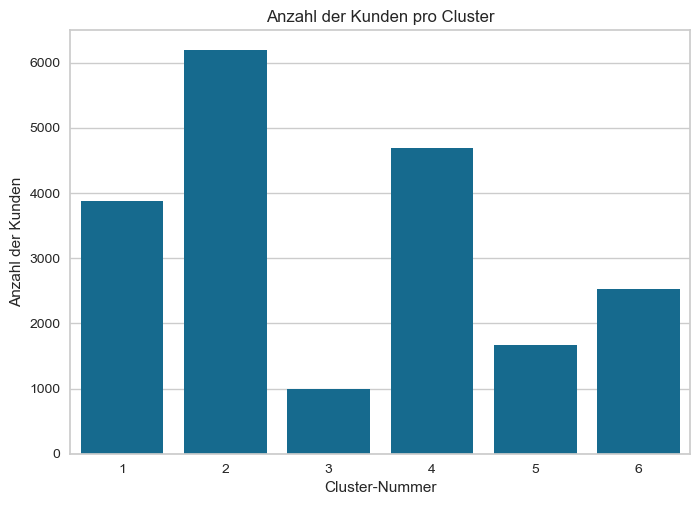

In [47]:
# Anzahl der Kunden pro Cluster
df["kmeans_cluster_no"].value_counts()

# Visualisierung mit Countplot
sns.countplot(x="kmeans_cluster_no", data=df)
plt.xlabel("Cluster-Nummer")     
plt.ylabel("Anzahl der Kunden")    
plt.title("Anzahl der Kunden pro Cluster") 
plt.show()

#Cluster 1

Größe: 3880 Kunden

Recency: Mittel (~0,55) → kürzlicher Kauf

Frequency: Niedrig (~1) → seltene Einkäufe

Monetary: Sehr niedrig (~0,01) → geringe Gesamtausgaben

Kommentar: Neue oder selten einkaufende Kunden. Zielgerichtete Marketingaktionen können Aktivität steigern.


#Cluster 2

Größe: 6187 Kunden

Recency: Sehr niedrig (~0,08) → Kauf liegt länger zurück

Frequency: Niedrig (~2)

Monetary: Niedrig (~0,015)

Kommentar: Kunden mit wenigen und unregelmäßigen Einkäufen. Anreize können sie zu Wiederkäufen motivieren.


#Cluster 3

Größe: 998 Kunden

Recency: Mittel (~0,70) → letzter Kauf vor kurzem

Frequency: Mittel (~3)

Monetary: Mittel (~0,026)

Kommentar: Aktivere und regelmäßig einkaufende Kunden, Treueprogramme können Wert steigern.
    

#Cluster 4

Größe: 4689 Kunden

Recency: Mittel (~0,30) → letzter Kauf relativ nah

Frequency: Niedrig (~1–2)

Monetary: Mittel (~0,012)

Kommentar: Regelmäßige Käufer mit geringem Umsatz, Upselling-Strategien möglich.


#Clusterr 5

Größe: 1662 Kunden

Recency: Mittel (~0,60)

Frequency: Mittel (~3–4)

Monetary: Mittel (~0,039) → höherer Umsatz im Vergleich zu anderen Clustern

Kommentar: Treue und wertvolle Kunden, gezielte Premium-Angebote oder Sonderaktionen.


#Cluster 6

Größe: 2529 Kunden

Recency: Sehr hoch (~0,87) → lange kein Kauf

Frequency: Sehr niedrig (~1)

Monetary: Sehr niedrig (~0,009)

Kommentar: Ehemalige oder verlorene Kunden, Rückgewinnungskampagnen sinnvoll.

#Zusammenfassung 

Hohe Recency + niedrige Frequency/Monetary: Rückgewinnungskampagnen (Cluster 6)

Niedrige Recency + mittlere Frequency/Monetary: Potenziell aktive Kunden (Cluster 3,5)

Neue oder inaktive Kunden: Marketingaktionen zur Reaktivierung (Cluster 1,2,4)

In [48]:
df.to_excel("kmeans_cluster_no.xlsx")


In [49]:
#Hierarchisches Clustering (Average Linkage)

# Nur numerische Spalten
X = df[numeric_cols]

# Standardisierung (Mittelwert = 0, Standardabweichung = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hierarchisches Clustering (Average Linkage)
hc_average = linkage(X_scaled, method="average")

X = df[numeric_cols]


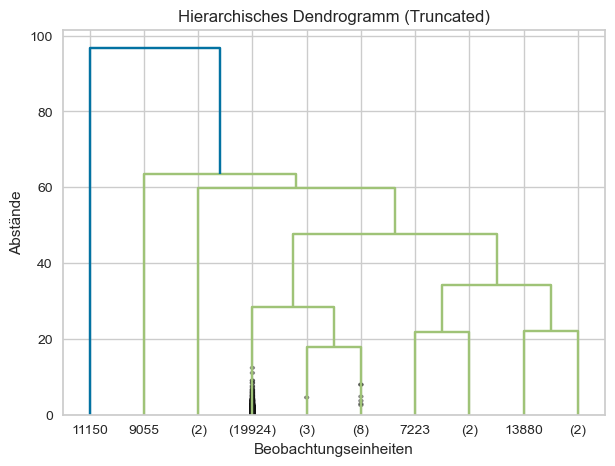

In [50]:
#Hierarchisches Dendrogramm (Truncated)

plt.figure(figsize=(7, 5))
plt.title("Hierarchisches Dendrogramm (Truncated)")
plt.xlabel("Beobachtungseinheiten")
plt.ylabel("Abstände")
dendrogram(
    hc_average,
    truncate_mode="lastp",  # nur die letzten p Verschmelzungen anzeigen
    p=10,                   # die größten 10 Verschmelzungen zeigen
    show_contracted=True,   # Informationen zu verschmolzenen Clustern
    leaf_font_size=10
)
plt.show()



Geschätzte Clusteranzahl für Schwellenwert 25: 7
Geschätzte Clusteranzahl für Schwellenwert 30: 6


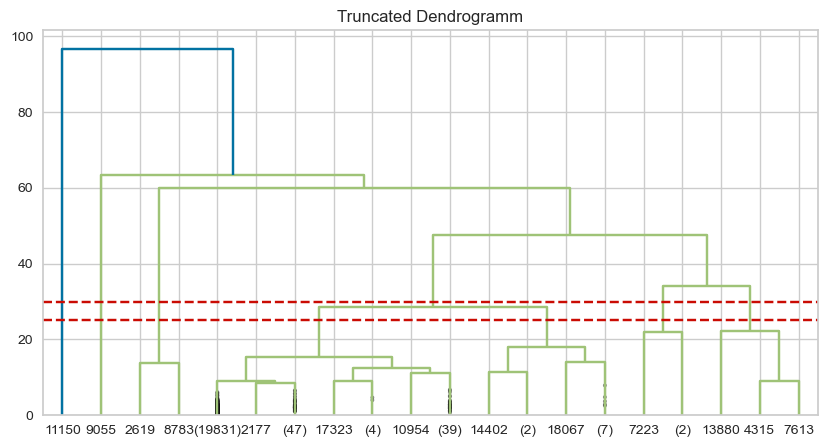

In [54]:
#Truncated Dendrogramm und geschätzte Clusteranzahl anhand von Schwellenwerten
from scipy.cluster.hierarchy import fcluster, dendrogram
import matplotlib.pyplot as plt

# Truncated Dendrogramm
plt.figure(figsize=(10, 5))
plt.title("Truncated Dendrogramm")
dend = dendrogram(
    hc_average,
    truncate_mode='lastp',
    p=20,
    show_contracted=True,
    leaf_font_size=10
)

# Schwellenwerte für die Clusterbestimmung
thresholds = [25, 30]

for y in thresholds:
    plt.axhline(y=y, color='r', linestyle='--')
    
    # Anzahl der Cluster basierend auf dem Schwellenwert
    clusters = fcluster(hc_average, t=y, criterion='distance')
    print(f"Geschätzte Clusteranzahl für Schwellenwert {y}: {len(set(clusters))}")

plt.show()


In [57]:
#Zuweisung der Cluster mit hierarchischem Clustering

# Hierarchisches Clustering
hc_cluster = AgglomerativeClustering(n_clusters=6, linkage="average")

# Vorhersage basierend auf den standardisierten numerischen Spalten
clusters_hc = hc_cluster.fit_predict(df[numeric_cols])

# Cluster-Nummern ab 1 starten
df["hi_cluster_no"] = clusters_hc + 1

# Erste 5 Zeilen anzeigen
df.head()


,CUST_ID,PURCHASE_CHANNEL,RECENT_CHANNEL,FIRST_PURCHASE_DATE,LAST_PURCHASE_DATE,LAST_ONLINE_DATE,LAST_OFFLINE_DATE,NUM_ORDERS_ONLINE,NUM_ORDERS_OFFLINE,SPEND_OFFLINE_TOTAL,SPEND_ONLINE_TOTAL,CATEGORIES_LAST12,RECENCY,TENURE,MONETARY,FREQUENCY,kmeans_cluster_no,hi_cluster_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,0.015,0.000,0.007,0.017,[KADIN],0.255,0.039,0.020,0.015,4,1
1,"""f431bd5a-ab7b-11e9-a2fc-000d3a38a36f",Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,0.090,0.009,0.008,0.041,"""""[ERKEK",0.282,0.484,0.043,0.095,5,1
2,"""69b69676-1a40-11ea-941b-000d3a38a36f",Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,0.010,0.009,0.010,0.008,"""""[ERKEK",0.504,0.121,0.012,0.015,1,2
3,"""1854e56c-491f-11eb-806e-000d3a38a36f",Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,0.000,0.000,0.002,0.002,"""""[AKTIFCOCUK",0.364,0.004,0.002,0.000,4,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,0.000,0.000,0.002,0.003,[AKTIFSPOR],0.230,0.192,0.004,0.000,4,1


In [61]:
## Clusterbasierte Zusammenfassung (nur numerische Spalten)
# Nur numerische Spalten ohne K-Means Cluster
numeric_cols_without_kmeans = [col for col in numeric_cols if col != "kmeans_cluster_no"]

# Clusterbasierte Zusammenfassung
df.groupby("hi_cluster_no")[numeric_cols_without_kmeans].agg(["count","mean","median"])

NUM_ORDERS_ONLINE              NUM_ORDERS_OFFLINE              SPEND_OFFLINE_TOTAL              SPEND_ONLINE_TOTAL              RECENCY              TENURE              MONETARY              FREQUENCY             
                          count  mean median              count  mean median               count  mean median              count  mean median   count  mean median  count  mean median    count  mean median     count  mean median
hi_cluster_no                                                                                                                                                                                                                      
1                          6347 0.014  0.005               6347 0.009  0.000                6347 0.014  0.010               6347 0.012  0.006    6347 0.269  0.279   6347 0.279  0.194     6347 0.017  0.012      6347 0.019  0.010
2                         10066 0.009  0.005              10066 0.008  0.000               10066 0.014  0.009              10066 0.010  0.006   10066 0.261  0.137  10066 0.171  0.173    10066 0.015  0.011     10066 0.013  0.010
3                          2529 0.005  0.000               2529 0.007  0.000                2529 0.011  0.008               2529 0.007  0.005    2529 0.871  0.882   2529 0.127  0.108     2529 0.011  0.009      2529 0.009  0.005
4                             4 0.595  0.525                  4 0.002  0.000                   4 0.029  0.022                  4 0.701  0.767       4 0.109  0.070      4 0.772  0.896        4 0.702  0.770         4 0.594  0.522
5                             1 0.005  0.005                  1 1.000  1.000                   1 0.565  0.565                  1 0.003  0.003       1 0.567  0.567      1 0.150  0.150        1 0.225  0.225         1 0.545  0.545
6                           998 0.021  0.010                998 0.008  0.000                 998 0.013  0.009                998 0.014  0.008     998 0.704  0.690    998 0.569  0.555      998 0.019  0.014       998 0.026  0.015

️#Cluster 1 (hi_cluster_no = 1)

Größe: 6347 Kunden → großer Cluster

Recency: Mittel (~0,27) → letzter Kauf relativ nah

Frequency: Mittel (~0,019)

Monetary: Mittel (~0,279)

Regelmäßige Kunden mit mittlerem Kaufverhalten. 


️#Cluster 2 (hi_cluster_no = 2)

Größe: 10066 Kunden → größter Cluster

Recency: Mittel (~0,26)

Frequency: Niedrig (~0,013)

Monetary: Mittel (~0,171)

Weniger aktive, große Kundengruppe. Durch Marketingmaßnahmen kann Aktivität gesteigert werden.


️#Cluster 3 (hi_cluster_no = 3)

Größe: 2529 Kunden

Recency: Hoch (~0,87) → lange kein Kauf

Frequency: Sehr niedrig (~0,009)

Monetary: Sehr niedrig (~0,127)

Ehemalige oder inaktive Kunden. Rückgewinnungskampagnen sinnvoll.
    

️#Clusterer 4 (hi_cluster_no = 4)

Größe: 4 Kunden → sehr kleiner Cluster

Recency / Frequency / Monetary: Sehr hoch oder Ausreißerwerte

Ausreißer / extreme Kunden. Können für die Analyse ausgeschlossen werden.
    

️#Cluster 5 (hi_cluster_no = 5)

Größe: 1 Kunde → einzelner Ausreißer

Definitiv ein Ausreißer, für normale Clusteranalyse nicht sinnvoll.

    
️#Cluster 6 (hi_cluster_no = 6)

Größe: 998 Kunden

Recency: Mittel (~0,70)

Frequency: Mittel (~0,026)

Monetary: Mittel (~0,569)

Treue und regelmäßige Kunden.

#Allgemeine Zusammenfassung 

Große Cluster mit mittlerem Verhalten: Cluster 1, 2, 6 → Marketingaktionen sinnvoll

Verlorene oder inaktive Kunden: Cluster 3 → Rückgewinnungskampagnen

Ausreißer / extreme Werte: Cluster 4 und 5 → können für Analyse ausgeschlossen werden